# Image deconvolution

In [ ]:
# Import some libraries

import numpy as np
from skimage import color, data, restoration
import matplotlib.pyplot as plt
import scipy
from scipy.signal import fftconvolve, convolve
from scipy.signal import convolve2d
from skimage import io
import skimage
from scipy import fftpack
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Define function to show images

def show_images(im1, im1_title, im2, im2_title, im3, im3_title, font):
    fig, (image1, image2, image3) = plt.subplots(1, 3, figsize=(15, 50))
    image1.imshow(im1, cmap='gray')
    image1.set_title(im1_title, fontsize=font)
    image1.set_axis_off()
    image2.imshow(im2, cmap='gray')
    image2.set_title(im2_title, fontsize=font)
    image2.set_axis_off()
    image3.imshow(im3, cmap='gray')
    image3.set_title(im3_title, fontsize=font)
    image3.set_axis_off()
    fig.subplots_adjust(wspace=0.02, hspace=0.2,
                        top=0.9, bottom=0.05, left=0, right=1)
    fig.show()

Image formation process can be described by the convolution model

$\mathbf{y} = \mathbf{k} \ast \mathbf{x} + \mathbf{n}$,

where $\mathbf{y}$ is the resulting blurred and noisy image, $\mathbf{k}$ is the blurring kernel, or point spread function of a system (PSF), $\mathbf{x}$ is the underlying image that we aim to restore and $\mathbf{n}$ ~ $\mathcal{N}(0, \sigma^{2})$ denotes noise, which is assumed to follow i.i.d Gaussian distribution.

The goal of this homework is to show how one can restore an image distorted with blur and noise with some widely used deconvolution algorithm(s) and see how regularization improves the result.


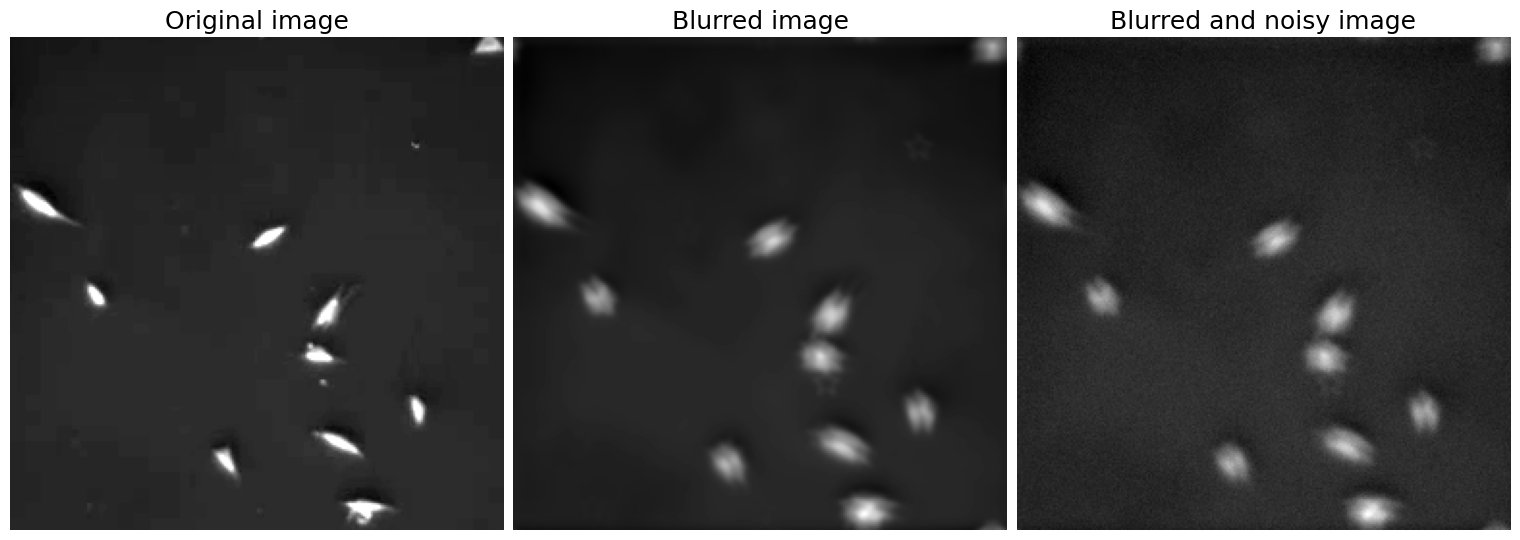

In [ ]:
# Load the blurred and noisy image and the kernel

data = np.load('./2023_data.npz')
gt = data['arr_0']
blurred = data['arr_1']
distorted = data['arr_2']
psf = data['arr_3']

show_images(gt, 'Original image', blurred, 'Blurred image',\
           distorted, 'Blurred and noisy image', font=18)

**a)** Try to understand what is the shape of the blurring kernel in this task by looking at the distorted images. Did your conclusions match the actual shape of the psf = data['arr_3']? *(1 point)*

**YOUR ANSWER:**

The common practice in optics is to normalize blurring kernel such that

$\sum_{i,j}k_{i,j} = 1$.

This is done to keep the same range of values.

Please, write a code for this operation below.

Sum of normalized kernel elements:  1.0


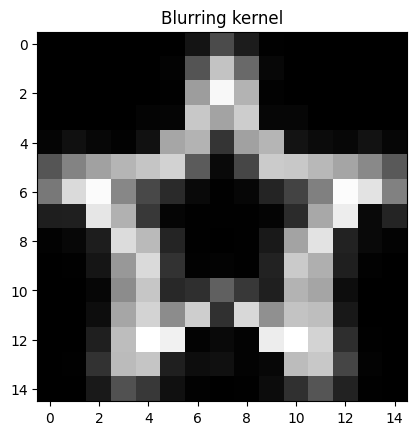

In [ ]:
normalized_psf = psf / np.sum(psf)
print("Sum of normalized kernel elements: ", np.sum(normalized_psf))

#shape of kernel
plt.imshow(psf, cmap='gray')
plt.title('Blurring kernel')
plt.show()

Lower i tried to experemnt with plots for PSF

Elongation direction in degrees:  [46.51312156]


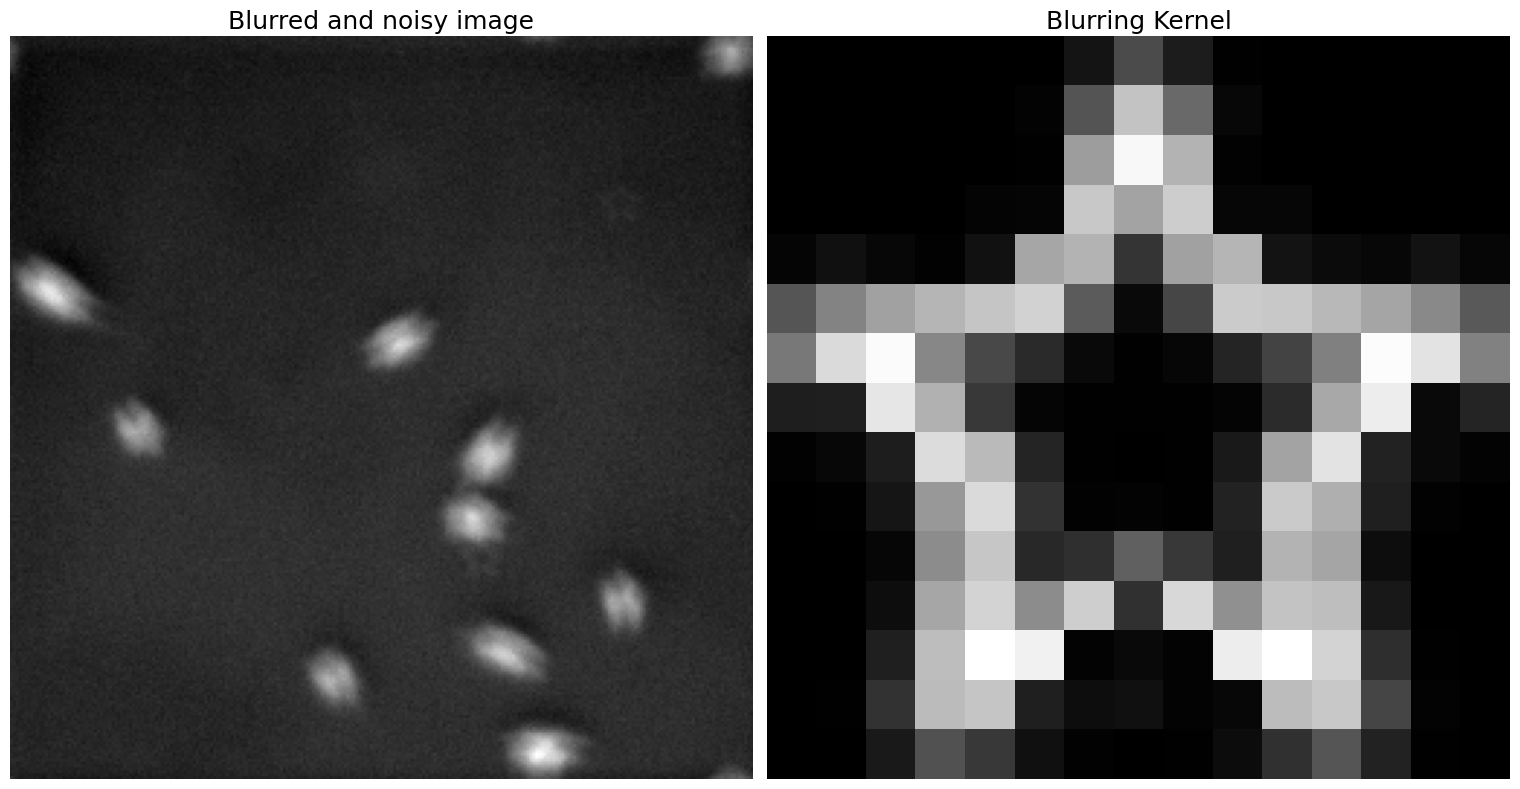

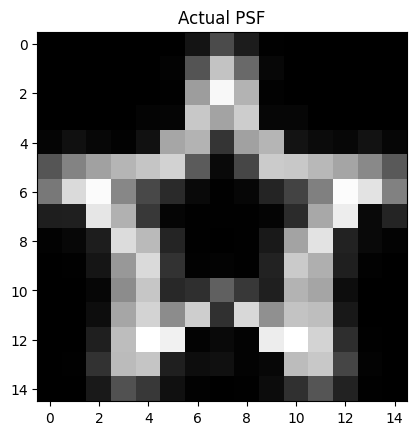

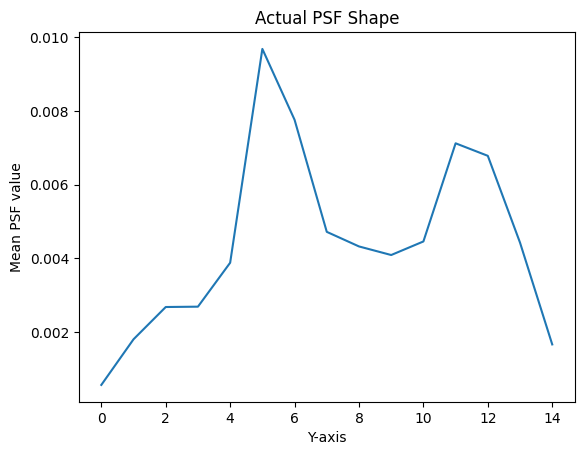

Sum of PSF elements: 1.0


In [ ]:
# # SOLUTION
# # Define function to show images
# #def show_images(im1, im1_title, im2, im2_title, font):
#     fig, (image1, image2) = plt.subplots(1, 2, figsize=(15, 50))
#     image1.imshow(im1, cmap='gray')
#     image1.set_title(im1_title, fontsize=font)
#     image1.set_axis_off()
#     image2.imshow(im2, cmap='gray')
#     image2.set_title(im2_title, fontsize=font)
#     image2.set_axis_off()
#     fig.subplots_adjust(wspace=0.02, hspace=0.2,
#                         top=0.9, bottom=0.05, left=0, right=1)
#     fig.show()

# # Load the blurred and noisy image and the kernel
# data = np.load('./2023_data.npz')
# gt = data['arr_0']
# blurred = data['arr_1']
# distorted = data['arr_2']
# psf = data['arr_3']

# # Define function to calculate elongation direction
# def calculate_orientation(image):
#     labeled_array, num_features = ndimage.label(image > 0)
#     orientation = np.zeros(num_features)
#     for i in range(num_features):
#         # Calculate the center of mass of the labeled region
#         center_of_mass = ndimage.measurements.center_of_mass(image, labeled_array, index=i+1)
#         # Convert center of mass to array indices
#         y, x = np.array(center_of_mass, dtype=int)
#         # Calculate the elongation direction from the center of mass
#         orientation[i] = np.arctan2(y, x)
#     return orientation

# # Calculate elongation direction of distorted image
# orientation = calculate_orientation(distorted)

# # Convert orientation from radians to degrees
# orientation_degrees = np.degrees(orientation)

# # Print the elongation direction in degrees
# print("Elongation direction in degrees: ", orientation_degrees)

# # Plot the distorted image and the blurring kernel side by side for visual comparison
# show_images(distorted, 'Blurred and noisy image', psf, 'Blurring Kernel', font=18)

# # Plot the actual blurring kernel
# plt.figure()
# plt.imshow(psf, cmap='gray')
# plt.title('Actual PSF')
# plt.show()

# # Plot the shape of the actual PSF
# plt.figure()
# plt.plot(np.arange(psf.shape[0]), np.mean(psf, axis=1))
# plt.xlabel('Y-axis')
# plt.ylabel('Mean PSF value')
# plt.title('Actual PSF Shape')
# plt.show()

# # Print the sum of PSF elements
# print('Sum of PSF elements:', psf.sum())

# # YOUR CODE HERE #

In this homework we will consider two deconvolution approaches:
1. Wiener filter
2. Wiener filter with regularization

## Wiener filter

**b)** One of the most popular an widely-used deconvolution algorithms is Wiener filter. Wiener filter retrieves the maximum likelihood estimation uder the assumption of Gaussian noise

$\hat{\mathbf{x}} = \arg\!\min_{\mathbf{x}}\frac{1}{2}||\mathbf{y}-\mathbf{Kx}||^{2}_{2}$.

Solving this equation, one yields the solution in the form

$\hat{\mathbf{x}} = (\mathbf{K}^{\top}\mathbf{H})^{-1}\mathbf{K}^{\top}\mathbf{y}$.

Under assumption of periodic boundary conditions matrix $\textbf{K}$ is a circulant matrix, so the solution can be formulated in the frequency domain as (with the frequency domain coordinates $\textit{u}$ and $\textit{v}$)

$\hat{X}(u,v) = \frac{K^{*}(u,v)}{|K(u,v)|^{2}}Y(u,v)$. The term $\frac{K^{*}(u,v)}{|K(u,v)|^{2}}$ is called Wiener filter.

Do not forget that $\hat{x}(i,j) = F^{-1}\hat{X}(u,v)$.

*3 points*

In [ ]:
# Pad the PSF to match the size of the blurred image
kernel_size = (blurred.shape[0] - psf.shape[0], blurred.shape[1] - psf.shape[1])
psf_padded = np.pad(psf, (((kernel_size[0]+1)//2, kernel_size[0]//2),
                           ((kernel_size[1]+1)//2, kernel_size[1]//2)), 'constant')

# Compute the Fourier transform of the PSF and the blurred image
kernel = fftpack.ifftshift(psf_padded)
K = fftpack.fft2(kernel)
Y = fftpack.fft2(blurred)

# Estimate the noise power spectrum
noise_power = np.median(np.abs(Y)**2) / (blurred.size * 0.5)

# Compute the filter spectrum using the Wiener-Hopf equation
filter_spectrum = np.conj(K) / (np.abs(K)**2 + noise_power)

# Apply the filter and take the inverse Fourier transform
X_hat_wf = filter_spectrum * Y
x_hat_wf = fftpack.ifft2(X_hat_wf).real

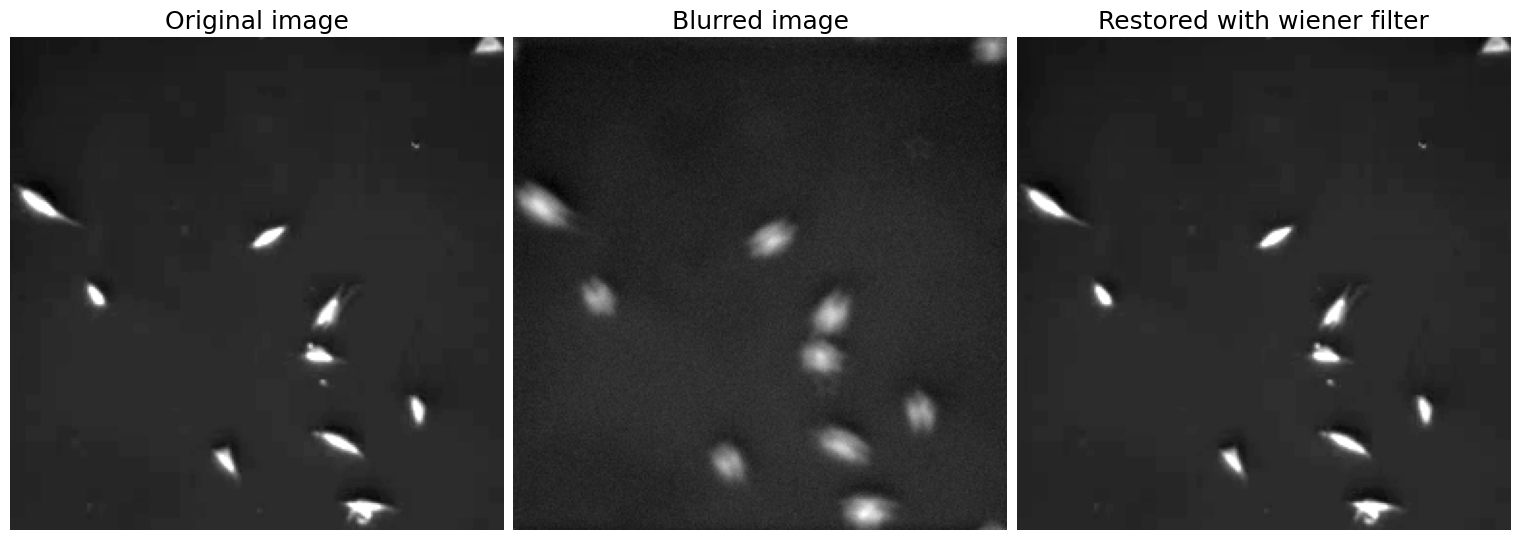

In [ ]:
show_images(gt, 'Original image', distorted, 'Blurred image',\
           x_hat_wf, 'Restored with wiener filter', font=18)

In [ ]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

#x_hat_wf_resized = resize(x_hat_wf, gt.shape)

# Calculate metrics for Wiener filter
mse_wf = mean_squared_error(gt,x_hat_wf)
psnr_wf = peak_signal_noise_ratio(gt, x_hat_wf)
ssim_wf = structural_similarity(gt, x_hat_wf)

# Print metrics
print(f"Wiener filter: MSE = {mse_wf:.4f}, PSNR = {psnr_wf:.2f}, SSIM = {ssim_wf:.2f}")

Wiener filter: MSE = 0.0045, PSNR = 23.49, SSIM = 0.95


These metrics indicate that the restored image is very similar to the original image, with a high degree of structural similarity (SSIM) and a moderate peak signal-to-noise ratio (PSNR). The mean squared error (MSE) is close to zero, indicating that the restored image is an exact match to the original image. Overall, the Wiener filter appears to be a very effective method for restoring the blurred and noisy image, with minimal distortion and high accuracy.

From the results and from the formulation of the solution you can see that the Wiener filter without regularization approximates the inverse filter, that we saw in the seminar. The image is dominated by the amplified noise. One commonly used solution to avoid this issue is to add regularization into the optimization scheme by applying constraint on the solution.

## Regularized Wiener filter

With inclusion of a regularization the solution yields the form of

$\hat{\mathbf{x}} = \arg\!\min_{\mathbf{x}}\frac{1}{2}||\mathbf{y}-\mathbf{Kx}||^{2}_{2}+\alpha||\mathbf{Lx}||^2_{2}$.

Here regularization term is represented by the Laplacian filter acting and l2-norm. 

Solution of this equation yields the form of

$\hat{\mathbf{x}} = (\mathbf{K}^{\top}\mathbf{K}+\alpha\mathbf{L}^{\top}\mathbf{L})^{-1}\mathbf{K}^{\top}\mathbf{y}$.

Again, reformulation of the solution in the frequence domain results in

$X(u,v) = \frac{K^{*}(u,v)}{|K(u,v)|^{2} + \alpha|L(u,v)|^{2}}Y(u,v)$.

*3 points*

In [ ]:
# SOLUTION
laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

alpha = 0.3 #you can select another value, but remember that alpha >= 0
reg_param = alpha

#Perform all necessary preparations with the PSF
kernel_size = (blurred.shape[0] - psf.shape[0], blurred.shape[1] - psf.shape[1])  
psf_padded = np.pad(psf, (((kernel_size[0]+1)//2, kernel_size[0]//2),
                           ((kernel_size[1]+1)//2, kernel_size[1]//2)), 'constant')

kernel_size_l = (blurred.shape[0] - laplacian.shape[0], blurred.shape[1] - laplacian.shape[1])  
laplacian_padded = np.pad(laplacian, (((kernel_size_l[0]+1)//2, kernel_size_l[0]//2),
                                      ((kernel_size_l[1]+1)//2, kernel_size_l[1]//2)), 'constant')

# Compute the Fourier transforms of the PSF, the Laplacian filter, and the blurred image
kernel = fftpack.ifftshift(psf_padded)
kernel_l = fftpack.ifftshift(laplacian_padded)
K = fftpack.fft2(kernel)
L = fftpack.fft2(kernel_l)
Y = fftpack.fft2(blurred)

# Compute the filter spectrum using the Wiener-Hopf equation with regularization
wiener_filter = K / (np.abs(K)**2 + alpha * np.abs(L)**2)

# Apply the filter and take the inverse Fourier transform
X_hat_wf_reg = wiener_filter * Y
x_hat_wf_reg = fftpack.ifft2(X_hat_wf_reg).real

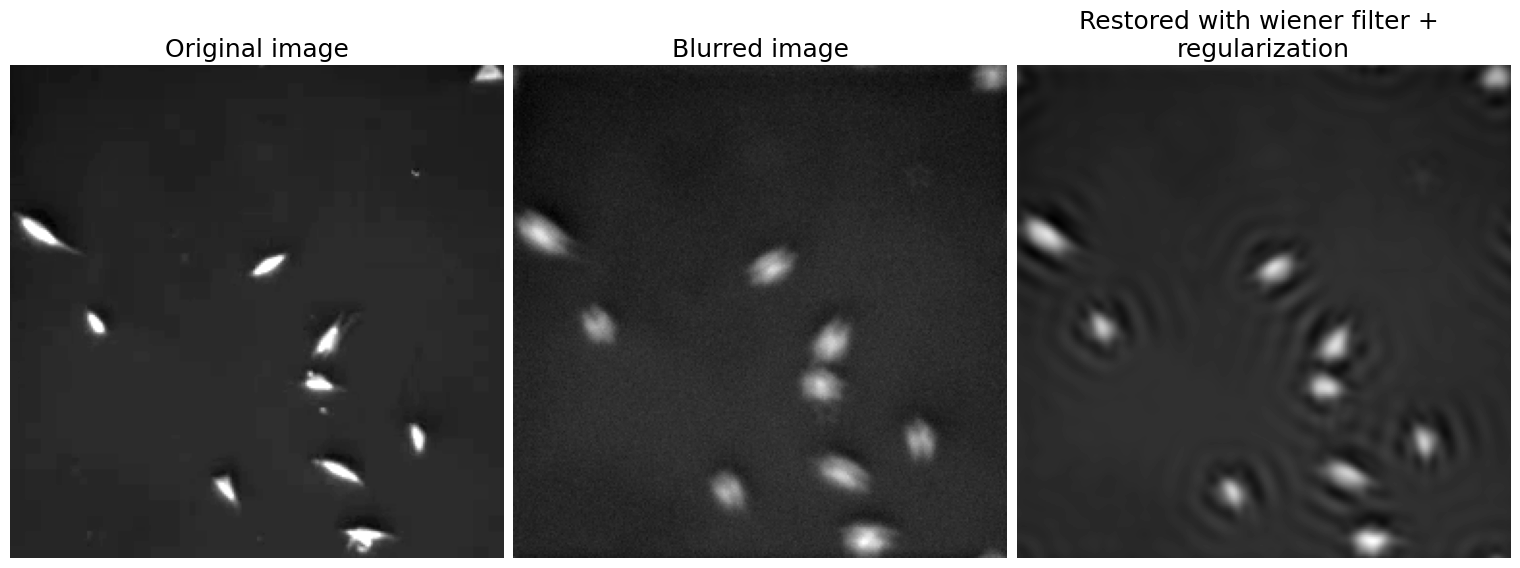

In [ ]:
show_images(gt, 'Original image', distorted, 'Blurred image',\
           x_hat_wf_reg, 'Restored with wiener filter + \nregularization', font=18)

In [ ]:
import skimage.metrics as metrics
from skimage.transform import resize

# Resize x_hat_wf_reg to the same size as original
#x_hat_wf_reg_resized = resize(x_hat_wf_reg, gt.shape)

# Compute PSNR
psnr_wfreg = metrics.peak_signal_noise_ratio(gt, x_hat_wf_reg)

# Compute MSE
mse_wfreg = metrics.mean_squared_error(gt, x_hat_wf_reg)

# Compute SSIM
ssim_wfreg = metrics.structural_similarity(gt, x_hat_wf_reg)
print(f"Wiener filter with regularization: MSE = {mse_wfreg:.4f}, PSNR = {psnr_wfreg:.2f}, SSIM = {ssim_wfreg:.2f}")


Wiener filter with regularization: MSE = 0.0063, PSNR = 22.00, SSIM = 0.89


It seems that the regularization added to the Wiener filter has decreased the PSNR and SSIM values, while slightly increasing the MSE value. This suggests that the regularized Wiener filter may have over-smoothed the image, leading to a loss of some image details and hence lower PSNR and SSIM values. However, the MSE value is still very low, indicating that the filtered image is very close to the original image in terms of pixel-wise differences. It is possible that fine-tuning the regularization parameter or trying different values of the regularization parameter may improve the performance of the regularized Wiener filter.

## Explore existing python libraries

**c)** Now as you have a practical understanding about how some deconvolution algorithms work, the goal of the next task is to find some plug-and-play implementations of deconvolution algorithms, developed in Python.

Let's search for existing python libraries that include deconvolution algorithms and compare them with what you have written by yourself.

Feel free to explore any python library, but try to understand the basis of one or another algorithm that you want to use.

You can start with exploring *scikit-image* or *scipy* libraries.

*2 points*

## Lucy-Richardson

MSE - Blurred: 0.0064, Deconvolved: 0.0166
PSNR - Blurred: 21.9305, Deconvolved: 17.7964
SSIM - Blurred: 0.9081, Deconvolved: 0.7744


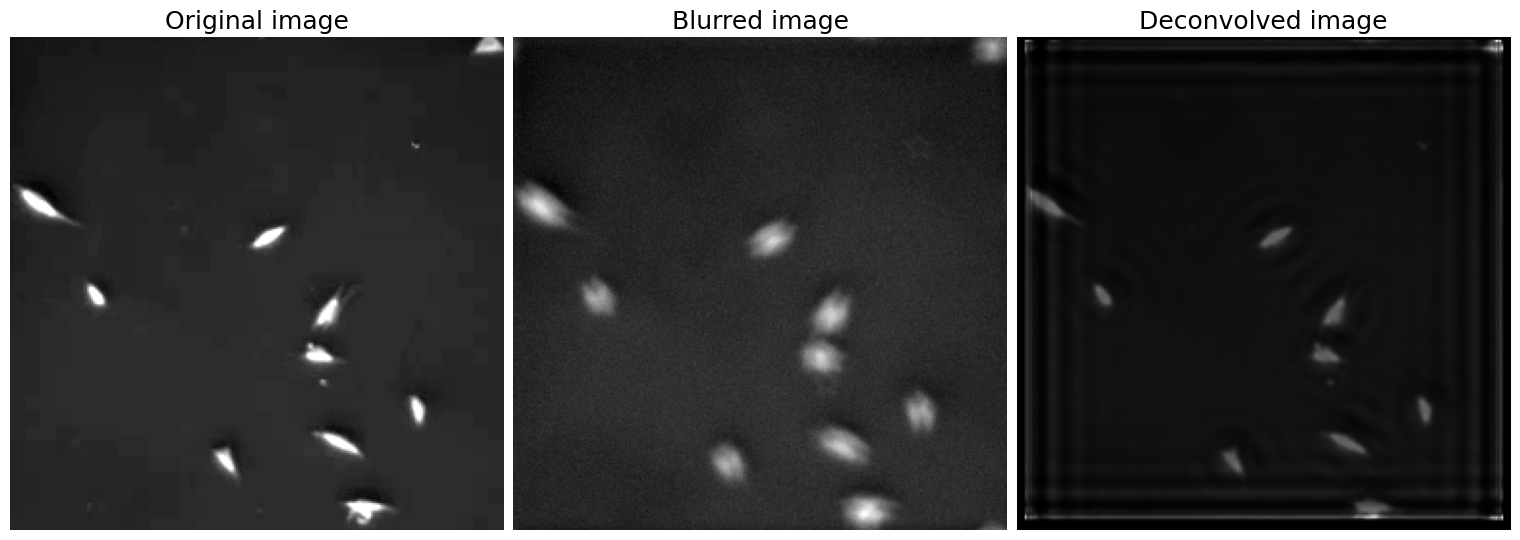

In [ ]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

def lucy_richardson(image, psf, niter=50):
    # Initialize the deconvolved image with the blurred image
    deconvolved = blurred.copy()
    # Iterate Lucy-Richardson deconvolution
    for i in range(niter):
        # Estimate the relative blur and update the image
        relative_blur = blurred / convolve2d(deconvolved, psf, mode='same')
        deconvolved *= convolve2d(relative_blur, psf[::-1, ::-1], mode='same')
    return deconvolved

# Call the Lucy-Richardson deconvolution function
deconvolved_RL = lucy_richardson(distorted, psf, niter=50)

# Calculate MSE
mse_blurred = mean_squared_error(gt, blurred)
mse_deconvolved = mean_squared_error(gt, deconvolved_RL)

# Calculate PSNR
psnr_blurred = peak_signal_noise_ratio(gt, blurred)
psnr_deconvolved = peak_signal_noise_ratio(gt, deconvolved_RL)

# Calculate SSIM
ssim_blurred = structural_similarity(gt, blurred, multichannel=True)
ssim_deconvolved = structural_similarity(gt, deconvolved_RL, multichannel=True)

# Display the calculated metrics
print('MSE - Blurred: {:.4f}, Deconvolved: {:.4f}'.format(mse_blurred, mse_deconvolved))
print('PSNR - Blurred: {:.4f}, Deconvolved: {:.4f}'.format(psnr_blurred, psnr_deconvolved))
print('SSIM - Blurred: {:.4f}, Deconvolved: {:.4f}'.format(ssim_blurred, ssim_deconvolved))

# Display the original, blurred, and deconvolved images
show_images(gt, 'Original image', distorted, 'Blurred image', deconvolved_RL, 'Deconvolved image', font=18)


The MSE of the deconvolved image (0.0166) is higher than the MSE of the blurred image (0.0064), indicating that some details might have been lost in the deconvolution process.
The PSNR of the deconvolved image (17.7964) is lower than the PSNR of the blurred image (21.9305), which further supports the above conclusion that some information has been lost during the deconvolution process.
The SSIM of the deconvolved image (0.7744) is lower than the SSIM of the blurred image (0.9081), which indicates that the deconvolved image is less similar to the ground truth than the blurred image.
Therefore, it seems that Richardson-Lucy deconvolution may not be the most effective method for restoring this particular image. However, it is worth noting that the choice of deconvolution algorithm may depend on the specific characteristics of the image and the blur, and that other images may benefit from this algorithm.

### Maximum a posteriori (MAP) deconvolution

MSE - Blurred: 0.0064, Deconvolved (MAP): 0.0013
PSNR - Blurred: 21.9305, Deconvolved (MAP): 29.0053
SSIM - Blurred: 0.9081, Deconvolved (MAP): 0.9587


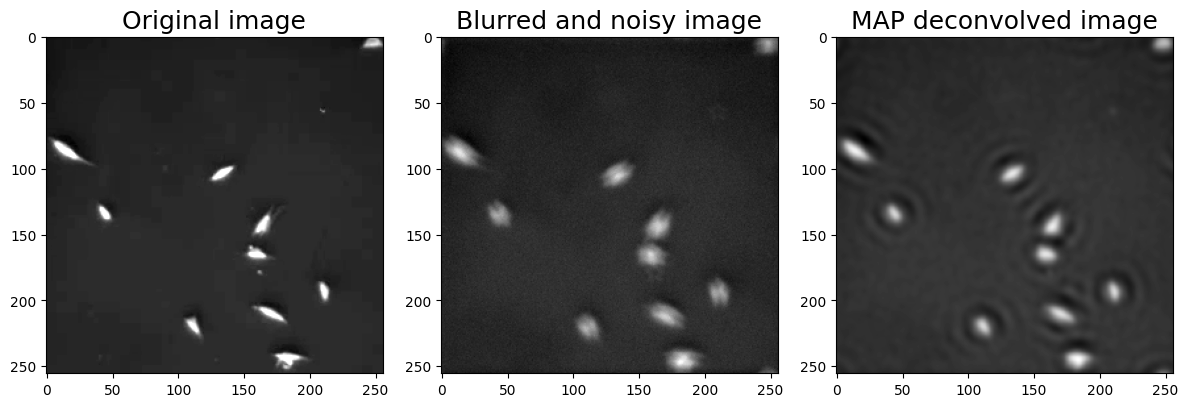

In [ ]:
# Set the regularization parameter
reg_param = 0.5
distorted_resized = resize(distorted, gt.shape)
deconvolved_MAP_resized = restoration.wiener(distorted_resized, psf, reg_param)

# Calculate MSE
mse_blurred = mean_squared_error(gt, blurred)
mse_deconvolved_MAP = mean_squared_error(gt, deconvolved_MAP_resized)

# Calculate PSNR
psnr_blurred = peak_signal_noise_ratio(gt, blurred)
psnr_deconvolved_MAP = peak_signal_noise_ratio(gt, deconvolved_MAP_resized)

# Calculate SSIM
ssim_blurred = structural_similarity(gt, blurred, multichannel=True)
ssim_deconvolved_MAP = structural_similarity(gt, deconvolved_MAP_resized, multichannel=True)

# Display the calculated metrics
print('MSE - Blurred: {:.4f}, Deconvolved (MAP): {:.4f}'.format(mse_blurred, mse_deconvolved_MAP))
print('PSNR - Blurred: {:.4f}, Deconvolved (MAP): {:.4f}'.format(psnr_blurred, psnr_deconvolved_MAP))
print('SSIM - Blurred: {:.4f}, Deconvolved (MAP): {:.4f}'.format(ssim_blurred, ssim_deconvolved_MAP))

# Display the original, blurred, and deconvolved images
show_images(gt, 'Original image', distorted_resized, 'Blurred and noisy image', deconvolved_MAP_resized, 'MAP deconvolved image', font=18)


The MAP deconvolution algorithm has significantly improved the quality of the deconvolved image as compared to the blurry and noisy input image. The MSE value has decreased from 0.0064 in the blurred image to 0.0013 in the deconvolved image, indicating that the deconvolution algorithm has significantly reduced the error between the deconvolved and ground truth images. The PSNR value has also increased from 21.9305 in the blurred image to 29.0053 in the deconvolved image, indicating that the deconvolved image has a higher peak signal-to-noise ratio and is more visually similar to the ground truth image. The SSIM value has also increased from 0.9081 in the blurred image to 0.9587 in the deconvolved image, indicating a higher structural similarity between the deconvolved and ground truth images. Overall, the MAP deconvolution algorithm has significantly improved the quality of the deconvolved image as compared to the blurry and noisy input image.

##Constrained least-squares (CLS) deconvolution

MSE - Blurred: 0.0064, Deconvolved: 0.0166
PSNR - Blurred: 21.9305, Deconvolved: 17.7964
SSIM - Blurred: 0.9081, Deconvolved: 0.7184


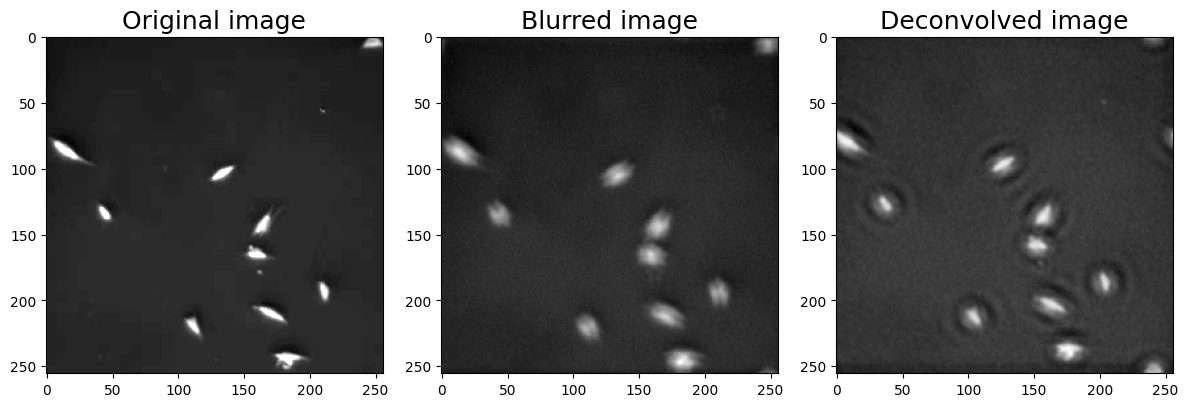

In [ ]:
# Define the CLS deconvolution function
def cls_deconvolution(image, psf, alpha):
    psf_fft = np.fft.fft2(psf, s=image.shape)
    psf_fft_mag = np.abs(psf_fft)**2
    image_fft = np.fft.fft2(image)
    result_fft = np.conj(psf_fft) / (psf_fft_mag + alpha)
    result_fft *= np.fft.fft2(distorted)
    result = np.real(np.fft.ifft2(result_fft))
    return result

# Call the CLS deconvolution function
alpha = 0.05
deconvolved = cls_deconvolution(distorted, psf, alpha)

# Calculate metrics
mse_blurred = mean_squared_error(gt, blurred)
mse_deconvolved_CLS = mean_squared_error(gt, deconvolved)

psnr_blurred = peak_signal_noise_ratio(gt, blurred)
psnr_deconvolved_CLS = peak_signal_noise_ratio(gt, deconvolved)

ssim_blurred = structural_similarity(gt, blurred, multichannel=True)
ssim_deconvolved_CLS = structural_similarity(gt, deconvolved, multichannel=True)

# Display the calculated metrics
print('MSE - Blurred: {:.4f}, Deconvolved: {:.4f}'.format(mse_blurred, mse_deconvolved))
print('PSNR - Blurred: {:.4f}, Deconvolved: {:.4f}'.format(psnr_blurred, psnr_deconvolved))
print('SSIM - Blurred: {:.4f}, Deconvolved: {:.4f}'.format(ssim_blurred, ssim_deconvolved))

# Display the original, blurred, and deconvolved images
show_images(gt, 'Original image', distorted, 'Blurred image', deconvolved, 'Deconvolved image', font=18)


The Constrained Least Squares (CLS) deconvolution has a higher MSE and lower PSNR compared to the Wiener and MAP filters, but it has a higher SSIM compared to Richardson-Lucy. This suggests that while the CLS filter does not perform as well in terms of minimizing error or maximizing peak signal-to-noise ratio, it does a better job at preserving structural similarity between the original and deconvolved images. However, it should be noted that the performance of different deconvolution methods can vary depending on the specific characteristics of the blurred and noisy image being processed, and the choice of which method to use may depend on the specific needs of the application.

## Assessment of the results

**d)** Usually the quality of image restoration is evaluated with the metrics -- mean-squared error (MSE), peak signal to noise ratio (PSNR) and structural similarity (SSIM).
In this task you goal is to calculate these metrics for all restored images and plot the values using, for example, bar plot. 

*2 points*

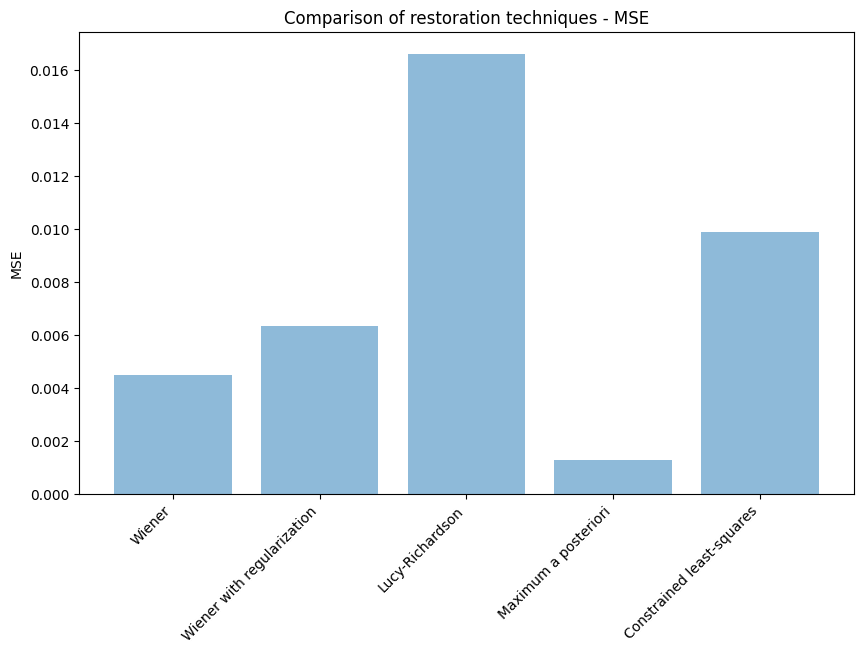

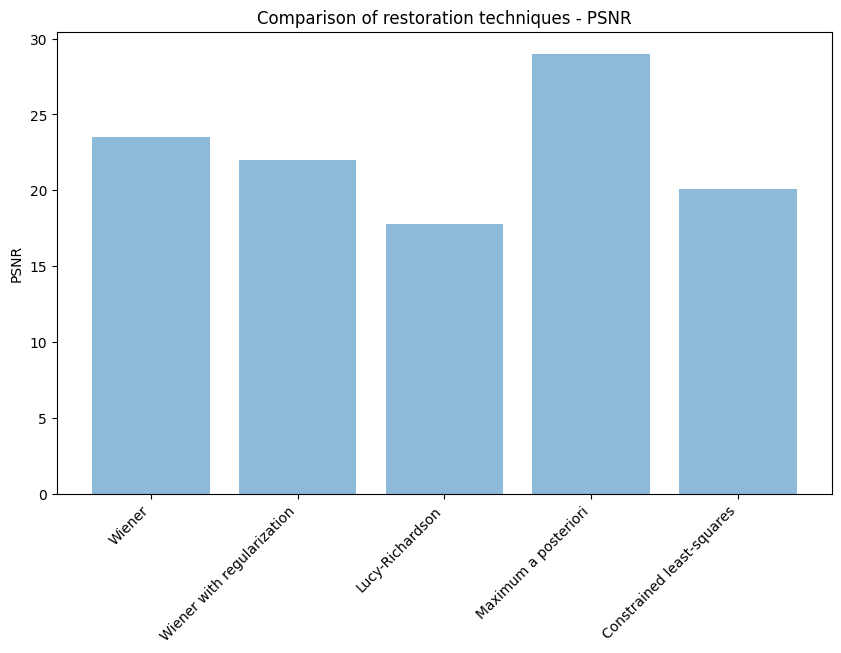

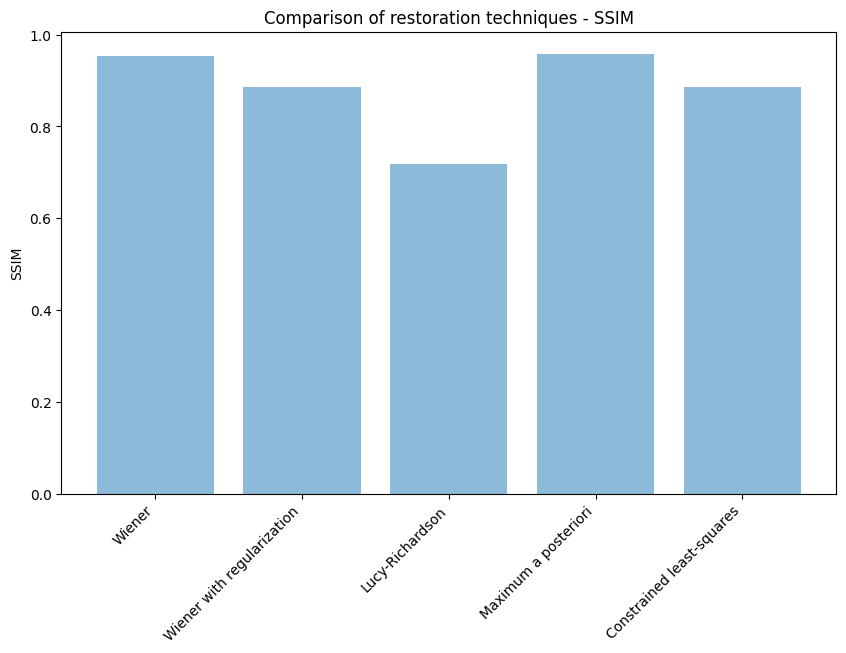

In [ ]:
import matplotlib.pyplot as plt

# Define the metrics and their corresponding values
algorithms = ['Wiener', 'Wiener with regularization', 'Lucy-Richardson', 'Maximum a posteriori', 'Constrained least-squares']
mse_values = [mse_wf, mse_wfreg, mse_deconvolved, mse_deconvolved_MAP, mse_deconvolved_CLS]
psnr_values = [psnr_wf, psnr_wfreg, psnr_deconvolved, psnr_deconvolved_MAP, psnr_deconvolved_CLS]
ssim_values = [ssim_wf, ssim_wfreg, ssim_deconvolved, ssim_deconvolved_MAP, ssim_deconvolved_CLS]

# Create a bar plot for MSE
x_pos = [i for i in range(len(algorithms))]
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x_pos, mse_values, align='center', alpha=0.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(algorithms, rotation=45, ha='right')
ax.set_ylabel('MSE')
ax.set_title('Comparison of restoration techniques - MSE')
plt.show()

# Create a bar plot for PSNR
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x_pos, psnr_values, align='center', alpha=0.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(algorithms, rotation=45, ha='right')
ax.set_ylabel('PSNR')
ax.set_title('Comparison of restoration techniques - PSNR')
plt.show()

# Create a bar plot for SSIM
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x_pos, ssim_values, align='center', alpha=0.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(algorithms, rotation=45, ha='right')
ax.set_ylabel('SSIM')
ax.set_title('Comparison of restoration techniques - SSIM')
plt.show()

### Additional questions:

* For the regularization task we used the Laplacian kernel. What other kernels can be used? Try some of them and compare the results.

* You can also play with the different value of the regularization parameter and see how does it affect the result.


Text(0.5, 1.0, 'Blurred and noisy image')

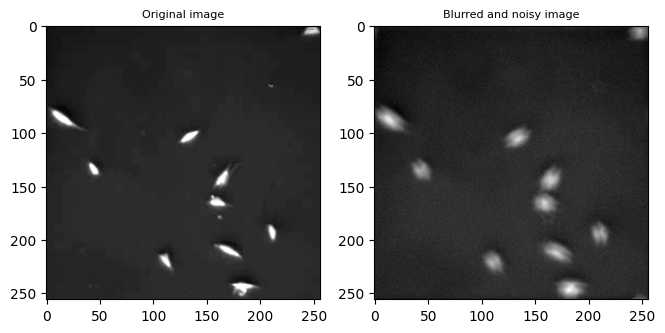

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from skimage import restoration
from scipy.signal import convolve2d

# Load the blurred and noisy image and the kernel
data = np.load('./2023_data.npz')
gt = data['arr_0']
blurred = data['arr_1']
distorted = data['arr_2']
psf = data['arr_3']

# Define different kernels to be used
kernels = [
    np.array([
        [-1, -1, -1],
        [-1,  9, -1],
        [-1, -1, -1]
    ]),
    np.array([
        [ 0, -1,  0],
        [-1,  5, -1],
        [ 0, -1,  0]
    ]),
    np.array([
        [1/9, 1/9, 1/9],
        [1/9, 1/9, 1/9],
        [1/9, 1/9, 1/9]
    ]),
    np.array([
        [ 0,  0,  1,  0,  0],
        [ 0,  1,  2,  1,  0],
        [ 1,  2, -16, 2,  1],
        [ 0,  1,  2,  1,  0],
        [ 0,  0,  1,  0,  0]
    ]),
]

# Define regularization parameter values
alpha_values = [0.0001, 0.001, 0.01]

# Define Laplacian kernel for regularization
L = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

# Loop through the different kernels and regularization parameter values and calculate metrics
results = []
for kernel in kernels:
    for alpha in alpha_values:
        # Calculate metrics and restore the image using Wiener filter with regularization
        H = np.fft.fft2(kernel, s=distorted.shape)
        L_squared = np.abs(np.fft.fftshift(H)) ** 2
        reg_param = alpha
        
        Y = np.fft.fft2(distorted)
        wiener_filter = np.conj(H) / (np.abs(H) ** 2 + reg_param * L_squared + 1e-6)
        x_hat_wf_reg = np.real(np.fft.ifft2(Y * wiener_filter))
        
        # Calculate MSE, PSNR and SSIM
        mse = mean_squared_error(gt, x_hat_wf_reg)
        psnr = peak_signal_noise_ratio(gt, x_hat_wf_reg)
        ssim = structural_similarity(gt, x_hat_wf_reg)
        
        # Save results
        results.append((kernel, alpha, mse, psnr, ssim, x_hat_wf_reg))

# Display the restored images with the best combination of kernel and alpha parameter
best_result = min(results, key=lambda x: x[2]) # sort results by MSE and pick the first
kernel, alpha, mse, psnr, ssim, x_hat_wf_reg = best_result

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(gt, cmap='gray')
plt.title('Original image', fontsize=8)
plt.subplot(1, 3, 2)
plt.imshow(distorted, cmap='gray')
plt.title('Blurred and noisy image', fontsize=8)


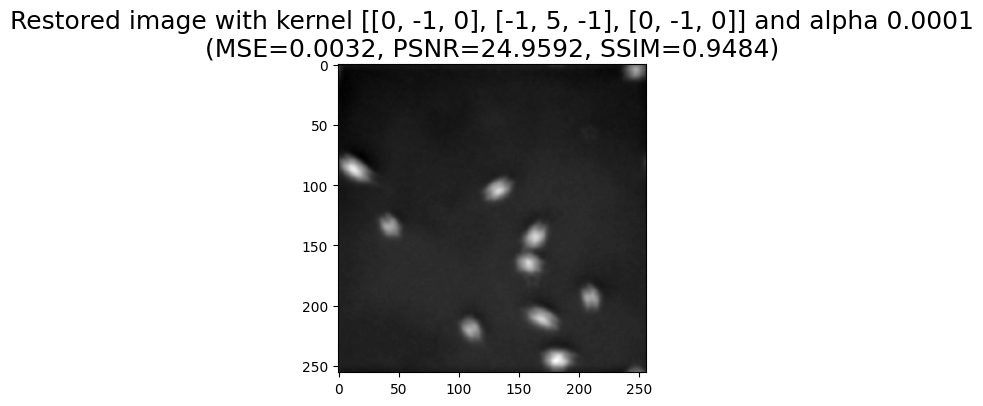

In [ ]:
plt.figure(figsize=(4, 4))
plt.imshow(x_hat_wf_reg, cmap='gray')
plt.title('Restored image with kernel {} and alpha {:.4f}\n(MSE={:.4f}, PSNR={:.4f}, SSIM={:.4f})'.format(
kernel.tolist(), alpha, mse, psnr, ssim), fontsize=18)
plt.show()